# Определение перспективного тарифа для телеком компании

Необходимо выяснить - какой тариф из двух приносит больше денег.

### Шаг 1. Открытие файла с данными и изучение общей информации

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import numpy as np

In [50]:
data_U = pd.read_csv('/datasets/users.csv') #  (информация о пользователях)
data_I = pd.read_csv('/datasets/internet.csv') # (информация о звонках)
data_C = pd.read_csv('/datasets/calls.csv') # (информация о сообщениях)
data_M = pd.read_csv('/datasets/messages.csv') # (информация об интернет-сессиях)
data_T = pd.read_csv('/datasets/tariffs.csv') # (информация о тарифах)

### Шаг 2. Подготовка данных

In [51]:
data_U.info()
data_U['churn_date'] = data_U['churn_date'].fillna(1)
data_U_N = data_U.query('churn_date == 1')
data_U_N['month'] = pd.DatetimeIndex(data_U_N['reg_date']).month
data_U_N.info()
print(data_U_N.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 462 entries, 0 to 499
Data columns (total 9 columns):
user_id       462 non-null int64
age           462 non-null int64
churn_date    462 non-null object
city          462 non-null object
first_name    462 non-null object
last_name     462 non-null object
reg_date      462 non-null object
tariff        462 non-null object
month         462 non-null int64
dtypes: int64(3), object(6)
memory usage: 36.1+ KB
   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52          1    Краснодар  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


38 пользователей (8%) отказались от услуг Мегалайн. Удалим их из общей выборки. smart потерял 23 (6%), ultra потерял 15 (10%). К тарифу подороже требования выше.

In [52]:
print(data_I.head())
data_I.info()
data_I_mb = data_I.query('mb_used > 0.00')
data_I_mb['month'] = pd.DatetimeIndex(data_I_mb['session_date']).month
print(data_I_mb.head())
data_I_mb.info()

       id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
       id  mb_used session_date  user_id  month
0  1000_0   112.95   2018-11-25     1000     11
1  1000_1  1052.81   2018-09-07     1000      9
2  1000_2  1197.26   2018-06-25     1000      6
3  1000_3   550.27   2018-08-22     1000      8
4  1000_4   302.56   2018-09-24     1000      9


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 5 columns):
id              129798 non-null object
mb_used         129798 non-null float64
session_date    129798 non-null object
user_id         129798 non-null int64
month           129798 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.9+ MB


13% записей имеют значение трафика ноль. Удаляем их - не берём их в расчёт.

In [53]:
print(data_C.head())
data_C.info()
data_C_d = data_C.query('duration > 0')
data_C_d['month'] = pd.DatetimeIndex(data_C_d['call_date']).month
print(data_C_d.head())
data_C_d.info()

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
       id   call_date  duration  user_id  month
2  1000_2  2018-06-11      2.85     1000      6
3  1000_3  2018-09-21     13.80     1000      9
4  1000_4  2018-12-15      5.18     1000     12
7  1000_7  2018-08-22     18.31     1000      8
8  1000_8  2018-09-15     18.44     1000      9
<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 5 columns):
id           162994 non-null object
call

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


20% звонков фиксирует ноль времени соединения. По всей видимости - эти звонки остались без ответа. Удаляем их.

In [54]:

data_M['month'] = pd.DatetimeIndex(data_M['message_date']).month
print(data_M.head())
data_M.info()

       id message_date  user_id  month
0  1000_0   2018-06-27     1000      6
1  1000_1   2018-10-08     1000     10
2  1000_2   2018-08-04     1000      8
3  1000_3   2018-06-16     1000      6
4  1000_4   2018-12-05     1000     12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
month           123036 non-null int64
dtypes: int64(2), object(2)
memory usage: 3.8+ MB


In [55]:
data_T.head()

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Подсчёт для каждого пользователя:

 - количество сделанных звонков

In [56]:
df_users = data_U_N[['user_id', 'tariff']]
df_users = df_users.set_index(['user_id'])
data_C_d_pivotTNcalls = data_C_d.pivot_table(index = ['user_id', 'month'], 
                                             values = 'duration', aggfunc = 'count')
data_C_d_pivotTNcalls = data_C_d_pivotTNcalls.reset_index()
print(data_C_d_pivotTNcalls.head())
data_Cal_Tariff = data_C_d_pivotTNcalls.merge(df_users, on = 'user_id')
data_Cal_Tariff.head()

   user_id  month  duration
0     1000      5        17
1     1000      6        28
2     1000      7        41
3     1000      8        42
4     1000      9        46


,user_id,month,duration,tariff
0,1000,5,17,ultra
1,1000,6,28,ultra
2,1000,7,41,ultra
3,1000,8,42,ultra
4,1000,9,46,ultra


Любое значение больше нуля будем считать за минуту и за мегабайт, т.к. «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [57]:
def func(row):
    if row['duration'] > 0:
        return math.ceil(row['duration'])
    return row['duration']

data_C_d['duration1'] = data_C_d.apply(func, axis=1)

data_C_d.info()
data_C_d.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 6 columns):
id           162994 non-null object
call_date    162994 non-null object
duration     162994 non-null float64
user_id      162994 non-null int64
month        162994 non-null int64
duration1    162994 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 8.7+ MB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,call_date,duration,user_id,month,duration1
2,1000_2,2018-06-11,2.85,1000,6,3
3,1000_3,2018-09-21,13.80,1000,9,14
4,1000_4,2018-12-15,5.18,1000,12,6
7,1000_7,2018-08-22,18.31,1000,8,19
8,1000_8,2018-09-15,18.44,1000,9,19


(duration1 столбец для бухгалтерии "Мегалайна")

 - и израсходованных минут разговора по месяцам;

In [58]:
data_C_d_pivotTsumM = data_C_d.pivot_table(index = ['user_id', 'month'],
                                           values = 'duration1', aggfunc = 'sum')


data_C_d_pivotTsumM = data_C_d_pivotTsumM.reset_index()
data_MiN_Tariff = data_C_d_pivotTsumM.merge(df_users, on = 'user_id')
data_MiN_Tariff.head()

,user_id,month,duration1,tariff
0,1000,5,159,ultra
1,1000,6,172,ultra
2,1000,7,340,ultra
3,1000,8,408,ultra
4,1000,9,466,ultra


 - количество отправленных сообщений по месяцам;

In [59]:
data_M_pivot = data_M.pivot_table(index = ['user_id', 'month'], 
                                       values = 'id', aggfunc = 'count')


data_M_Tariff = data_M_pivot.reset_index()
data_M_Tariff = data_M_Tariff.merge(df_users, on = 'user_id')
data_M_Tariff.head()

,user_id,month,id,tariff
0,1000,5,22,ultra
1,1000,6,60,ultra
2,1000,7,75,ultra
3,1000,8,81,ultra
4,1000,9,57,ultra


 - объем израсходованного интернет-трафика по месяцам;

In [60]:
def func(row):
    if row['mb_used'] > 0:
        return math.ceil(row['mb_used'])
    return row['mb_used']

data_I_mb['mb_used1'] = data_I_mb.apply(func, axis=1)


data_I_mb.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,mb_used,session_date,user_id,month,mb_used1
0,1000_0,112.95,2018-11-25,1000,11,113
1,1000_1,1052.81,2018-09-07,1000,9,1053
2,1000_2,1197.26,2018-06-25,1000,6,1198
3,1000_3,550.27,2018-08-22,1000,8,551
4,1000_4,302.56,2018-09-24,1000,9,303


- помесячную выручку с каждого пользователя

In [61]:
data_I_mb_pivot = data_I_mb.pivot_table(index = ['user_id', 'month'],
                                        values = 'mb_used1', aggfunc = 'sum')


data_MB_Tariff = data_I_mb_pivot.reset_index()


data_MB_Tariff = data_MB_Tariff.merge(df_users, on = 'user_id')




data_S_Tariff = data_MiN_Tariff.merge(data_M_Tariff,
                                      on = ['user_id','tariff', 'month'], how='outer')

data_V_Tariff = data_S_Tariff.merge(data_MB_Tariff,
                                      on = ['user_id','tariff', 'month'], how='outer')

data_T['tariff'] = data_T['tariff_name']

data_U_Tariff = data_V_Tariff.merge(data_T, on = 'tariff')

data_U_Tariff = data_U_Tariff.fillna(0)


def function1(data):
    data['SUMmin'] = (data['duration1'] - data['minutes_included']) * data['rub_per_minute']
    if data['SUMmin'] > 0:
        return data['SUMmin']
    return 0

def function2(data):
    data['SUMsoob'] = (data['id'] - data['messages_included']) * data['rub_per_message']
    if data['SUMsoob'] > 0:
        return data['SUMsoob']
    return 0

def function3(data):
    data['SUMmb'] = ((data['mb_used1'] - data['mg_per_month_included']) / 1024) * data['rub_per_gb']
    if data['SUMmb'] > 0:
        return data['SUMmb']
    return 0


data_U_Tariff['SUMmin'] = data_U_Tariff.apply(function1, axis=1)

data_U_Tariff['SUMsoob'] = data_U_Tariff.apply(function2, axis=1)

data_U_Tariff['SUMmb'] = data_U_Tariff.apply(function3, axis=1)

data_U_Tariff['SUM'] = (data_U_Tariff['SUMmin'] + data_U_Tariff['SUMsoob'] + data_U_Tariff['SUMmb'] +
                        data_U_Tariff['rub_monthly_fee'])

data_U_Tariff.head(1000)

,user_id,month,duration1,tariff,id,mb_used1,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,SUMmin,SUMsoob,SUMmb,SUM
0,1000,5,159.0,ultra,22.0,2256.0,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.000000,1950.000000
1,1000,6,172.0,ultra,60.0,23257.0,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.000000,1950.000000
2,1000,7,340.0,ultra,75.0,14016.0,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.000000,1950.000000
3,1000,8,408.0,ultra,81.0,14070.0,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.000000,1950.000000
4,1000,9,466.0,ultra,57.0,14581.0,1000,30720,3000,1950,150,1,1,ultra,0.0,0.0,0.000000,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1015,5,401.0,smart,73.0,17170.0,50,15360,500,550,200,3,3,smart,0.0,69.0,353.515625,972.515625
996,1015,6,430.0,smart,80.0,26926.0,50,15360,500,550,200,3,3,smart,0.0,90.0,2258.984375,2898.984375
997,1015,7,556.0,smart,90.0,19933.0,50,15360,500,550,200,3,3,smart,168.0,120.0,893.164062,1731.164062
998,1015,8,394.0,smart,68.0,27436.0,50,15360,500,550,200,3,3,smart,0.0,54.0,2358.593750,2962.593750


Для наглядности продемонстрированы фрагменты таблицы с разными тарифами.

### Шаг 3.Анализ данных
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Статистические показатели
 - по количеству затраченных минут разговора за месяц

ULTRA
count     909.000000
mean      531.930693
std       320.472257
min         0.000000
25%       286.000000
50%       523.000000
75%       753.000000
max      1673.000000
Name: duration1, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


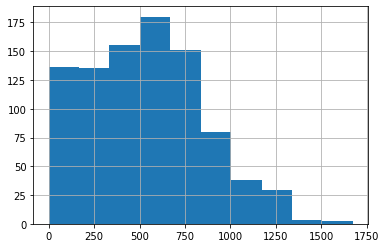


SMART
count    2118.000000
mean      422.773843
std       191.203948
min         0.000000
25%       287.250000
50%       430.000000
75%       550.000000
max      1435.000000
Name: duration1, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


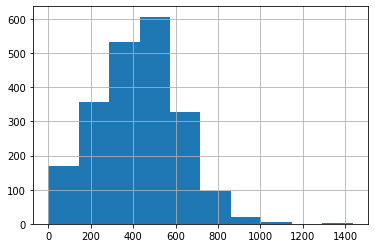

In [62]:
data_U_Tariff_ULTRA = data_U_Tariff.query('tariff_name == "ultra"')
data_U_Tariff_SMART = data_U_Tariff.query('tariff_name == "smart"')
print('Статистические показатели')
print(' - по количеству затраченных минут разговора за месяц')
print()
print('ULTRA')
print(data_U_Tariff_ULTRA['duration1'].describe())
print(data_U_Tariff_ULTRA['duration1'].hist())
plt.show()
print()
print('SMART')
print(data_U_Tariff_SMART['duration1'].describe())
print(data_U_Tariff_SMART['duration1'].hist())
plt.show()

Гистограмма по тарифу "Смарт" демонстрирует распределение более похожее на нормальное. Кажется, что мало данных... Превышение лимита по тарифу "Смарт" частое явление.

 - по количеству сообщений за месяц

ULTRA
count    909.000000
mean      51.218922
std       48.344162
min        0.000000
25%        9.000000
50%       40.000000
75%       80.000000
max      224.000000
Name: id, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


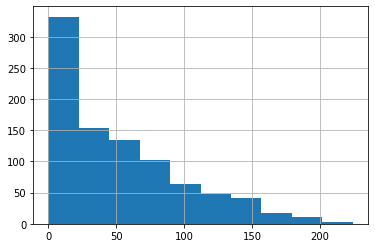


SMART
count    2118.000000
mean       33.587819
std        28.440087
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: id, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


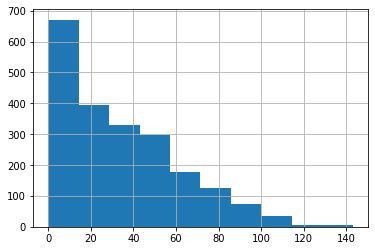

In [63]:
print(' - по количеству сообщений за месяц')
print()
print('ULTRA')
print(data_U_Tariff_ULTRA['id'].describe())
print(data_U_Tariff_ULTRA['id'].hist())
plt.show()
print()
print('SMART')
print(data_U_Tariff_SMART['id'].describe())
print(data_U_Tariff_SMART['id'].hist())
plt.show()

Обе гистограмма демонстрируют классический вид распределения Пуасона со скосом вправо. Также говорит, что маловато данных. 1000 сообщений в месяц пользователям тарифа "Ультра" не нужно.

 - по объёму интернет-трафика за месяц

ULTRA
count      909.00000
mean     19608.79758
std       9990.02500
min          0.00000
25%      11876.00000
50%      19374.00000
75%      27170.00000
max      49789.00000
Name: mb_used1, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


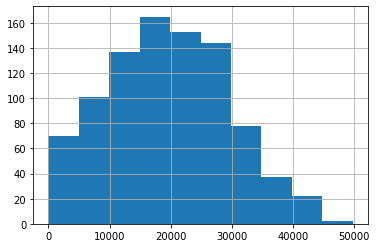


SMART
count     2118.000000
mean     16294.444287
std       5842.884783
min          0.000000
25%      12753.750000
50%      16566.500000
75%      20068.000000
max      38610.000000
Name: mb_used1, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


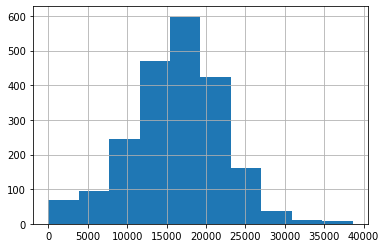

In [64]:
print(' - по объёму интернет-трафика за месяц')
print()
print('ULTRA')
print(data_U_Tariff_ULTRA['mb_used1'].describe())
print(data_U_Tariff_ULTRA['mb_used1'].hist())
plt.show()
print()
print('SMART')
print(data_U_Tariff_SMART['mb_used1'].describe())
print(data_U_Tariff_SMART['mb_used1'].hist())
plt.show()

Гистограмма по тарифу "Смарт" демонстрирует распределение более похожее на нормальное. Кажется, что мало данных...Пользователи тарифа "Смарт" часто превышают лимит трафика по тарифу.

# Шаг 4. Проверьте гипотезы
средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
Пороговое значение alpha задайте самостоятельно.
Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему.

In [65]:
print('Средняя выручка пользователей тарифов «Ультра»')
print(data_U_Tariff_ULTRA['SUM'].describe())
print()
print('Средняя выручка пользователей тарифов «Смарт»')
print(data_U_Tariff_SMART['SUM'].describe())

data_U_Tariff['city'] = data_U_N['city']
print()
print('Cредняя выручка пользователей из Москвы')
data_U_Tariff_Moskva = data_U_Tariff.query('city == "Москва"')
print(data_U_Tariff_Moskva['SUM'].describe())
print()
print('Cредняя выручка пользователей из других регионов России')
data_U_Tariff_Ostalnaia_Russia = data_U_Tariff.query('city != "Москва"')
print(data_U_Tariff_Ostalnaia_Russia['SUM'].describe())

Средняя выручка пользователей тарифов «Ультра»
count     909.000000
mean     2057.306492
std       348.828733
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4743.310547
Name: SUM, dtype: float64

Средняя выручка пользователей тарифов «Смарт»
count    2118.000000
mean     1242.613746
std       791.565987
min       550.000000
25%       562.000000
50%       974.777344
75%      1674.267578
max      6711.015625
Name: SUM, dtype: float64

Cредняя выручка пользователей из Москвы
count      90.000000
mean     2164.934896
std       509.912966
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      3945.263672
Name: SUM, dtype: float64

Cредняя выручка пользователей из других регионов России
count    2937.000000
mean     1466.497574
std       781.547905
min       550.000000
25%       690.234375
50%      1480.726562
75%      1950.000000
max      6711.015625
Name: SUM, dtype: float64


### Москва и другие регионы

Нулевая гипотеза: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов

In [93]:
alpha = .05

Moskva = data_U_Tariff_Moskva['SUM'].tolist()
Ostalnaia_Russia = data_U_Tariff_Ostalnaia_Russia['SUM'].tolist()

results = st.ttest_ind(Ostalnaia_Russia, Moskva)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.616096438913594e-17
Отвергаем нулевую гипотезу


Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

### «Ультра» и  «Смарт»

Нулевая гипотеза: средняя выручка пользователей тарифов «Ультра» и средняя выручка пользователей тарифов «Смарт» одинаковые.

In [72]:
alpha = .05

ULTRA = data_U_Tariff_ULTRA['SUM'].tolist()
SMART = data_U_Tariff_SMART['SUM'].tolist()

results = st.ttest_ind(ULTRA, SMART)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.966126159965563e-171
Отвергаем нулевую гипотезу


Средняя выручка пользователей тарифов «Ультра» и средняя выручка пользователей тарифов «Смарт» отличаются.

# Шаг 5. Напишите общий вывод

In [92]:
ULTRAsum = data_U_Tariff_ULTRA['SUM'].sum()
ULTRAcount = data_U_Tariff_ULTRA['SUM'].count()
SMARTsum = data_U_Tariff_SMART['SUM'].sum()
SMARTcount = data_U_Tariff_SMART['SUM'].count()

print('Тарифные предпочтения пользователей из Москвы', data_U_Tariff_Moskva['tariff'].value_counts())

data = [['SMART', SMARTcount, int(SMARTsum), int(int(SMARTsum)/ SMARTcount)], 
       ['ULTRA', ULTRAcount, int(ULTRAsum), int(int(ULTRAsum)/ ULTRAcount)]] 
columns = ['Тариф','Человекомесяцы','Выручка от тарифа','Удельная выручка c одного человекомесяца '] 
Tarif = pd.DataFrame(data = data, columns = columns) 

Tarif

Тарифные предпочтения пользователей из Москвы ultra    90
Name: tariff, dtype: int64


,Тариф,Человекомесяцы,Выручка от тарифа,Удельная выручка c одного человекомесяца
0,SMART,2118,2631855,1242
1,ULTRA,909,1870091,2057


Комерческому департаменту сказать, что бы тратили деньги на рекламу тарифа "Ультра" в Москве. Суммарная выручка от тарифа "Смарт" выше, чем от тарифа "Ультра". Несмотря на то, что человекомесяцев в 2 раза больше у Смарта, тем не менее у него только в 1,5 раза больше выручка.